In [1]:
library(tidyverse)
library(networkD3)
library(htmlwidgets)
library(webshot)
library(RColorBrewer)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘htmlwidgets’

The following object is masked from ‘package:networkD3’:

    JS



# Constants

In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
dsets <- c("unified_cervical_data")
dset_paths <- unlist(map(dsets, function(d) paste0(dirs$data_dir, "/", d)))
matrisome_list <- matrisome_list <- paste(dirs$data_dir, "matrisome", "matrisome_hs_masterlist.tsv", sep = "/")
dset_idx <- 1

## Functions

In [3]:
to_vplot_df <- function(df) {
    vplot_df <- df %>%
        dplyr::rename(log2_fc = log2FoldChange) %>%
        dplyr::rename(gene_ID = geneID) %>%
        dplyr::rename(base_mean = baseMean) %>%
        dplyr::mutate(neg_log10_padj = -log10(padj)) %>%
        dplyr::select(gene_ID, base_mean, log2_fc, neg_log10_padj, padj, pvalue)
    return(vplot_df)
}


make_vplot <- function(df, add_contour = FALSE, jitter_w = 0, jitter_h = 0) {
    plt <- ggplot(df) +
        aes(y = neg_log10_padj, x = log2_fc) +
        geom_point(size = 1, position = position_jitter(w = jitter_w, h = jitter_h)) +
        {if (add_contour) geom_density2d(aes(colour=..level..))} +
        {if (add_contour) scale_colour_gradient(low = "#00e600", high="#cc0000", name = "Density")} +
        geom_hline(yintercept = -log10(0.05), linetype = "longdash", colour = "#737373", size = 0.5) +
        geom_vline(xintercept = log2(2), linetype = "longdash", colour = "#BE684D", size = 0.5) +
        geom_vline(xintercept = -1, linetype = "longdash", colour = "#2C467A", size = 0.5) +
        labs(title = "Matrisome DEG Analysis",
            subtitle = "CESC") +
        xlab("log2 fold-change") +
        ylab("-log10(adj. p-val)") +
        guides(alpha="none")

    return(plt)
}

## Load data

In [4]:
dge_matrisome_rj_df <- read_tsv(paste(dirs$analysis_dir, "unified_cervical_data_all_matrisome_xref_unified_data.tsv", sep = "/"))
all_genes_df <- read_tsv(paste(dirs$analysis_dir, "unified_cervical_data_unfiltered_DESeq_results.tsv", sep = "/"))

Parsed with column specification:
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double(),
  in_unified_dataset = col_logical(),
  division = col_character(),
  category = col_character(),
  gene_name = col_character(),
  synonyms = col_character(),
  hgnc_ids = col_double(),
  hgnc_ids_links = col_double(),
  uniprot_ids = col_character(),
  refseq_ids = col_character(),
  orthology = col_character(),
  notes = col_character()
)
Parsed with column specification:
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double()
)


In [5]:
matrisome_vplot_df <- to_vplot_df(dge_matrisome_rj_df)
head(matrisome_vplot_df)
all_gene_vplot_df <- to_vplot_df(all_genes_df)
head(all_gene_vplot_df)

gene_ID,base_mean,log2_fc,neg_log10_padj,padj,pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PGF,1439.047628,1.7961389,0.66322047,0.217159847,0.0951010364
TIMP4,49.579600,-2.5000604,0.62465283,0.237327013,0.1075551535
C1QTNF6,1663.611171,0.8317585,0.30229730,0.498543085,0.3190224832
TNC,14887.584519,0.1505524,0.02556824,0.942826451,0.8976652543
PRL,4.336559,-4.5906659,0.85234166,0.140494183,0.0519566391
OGN,586.195062,-7.1447904,2.83556291,0.001460283,0.0001612998


gene_ID,base_mean,log2_fc,neg_log10_padj,padj,pvalue
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FAM208A,3860.14546,-0.2149325,0.1832043,6.558367e-01,4.901354e-01
RADIL,104.93138,-3.0232035,1.4704550,3.384894e-02,7.889156e-03
AP1M2,3874.62069,6.4941253,22.1433864,7.188091e-23,3.413226e-25
TAF1,2646.98788,-0.2624898,0.1950149,6.382416e-01,4.692465e-01
SIGLEC5,40.27324,0.6549272,0.1640595,6.853943e-01,5.261147e-01
KLF1,6.54729,4.0359685,1.3606222,4.358909e-02,1.103403e-02


## Volcano plots

Warning message:
“Removed 119 rows containing missing values (geom_point).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 119 rows containing missing values (geom_point).”Warning message:
“Removed 2552 rows containing missing values (geom_point).”

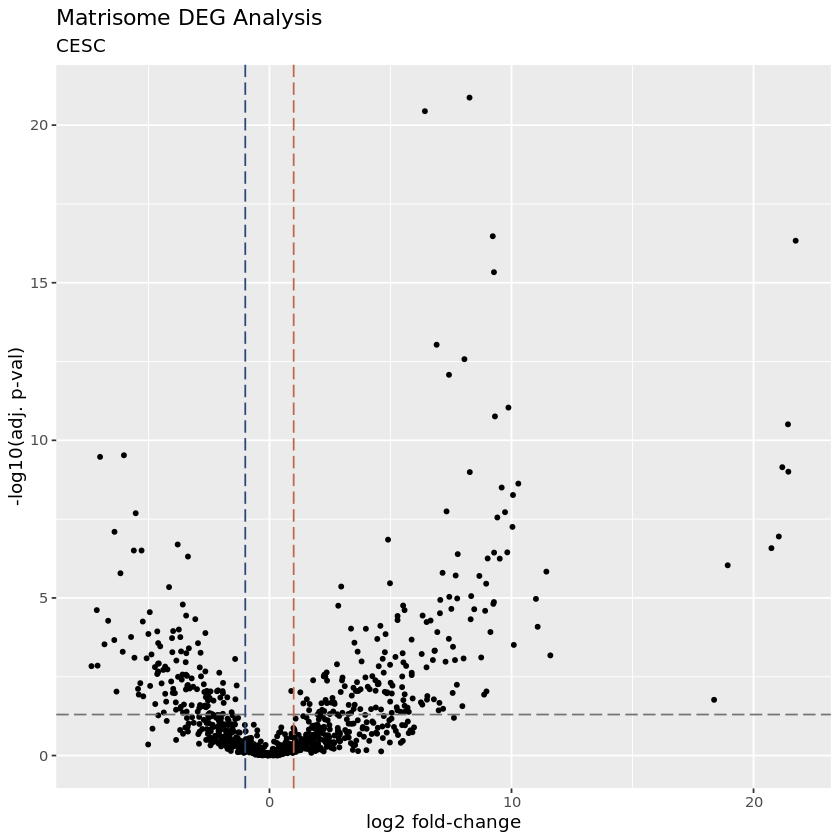

Saving 6.67 x 6.67 in image
Warning message:
“Removed 2552 rows containing missing values (geom_point).”

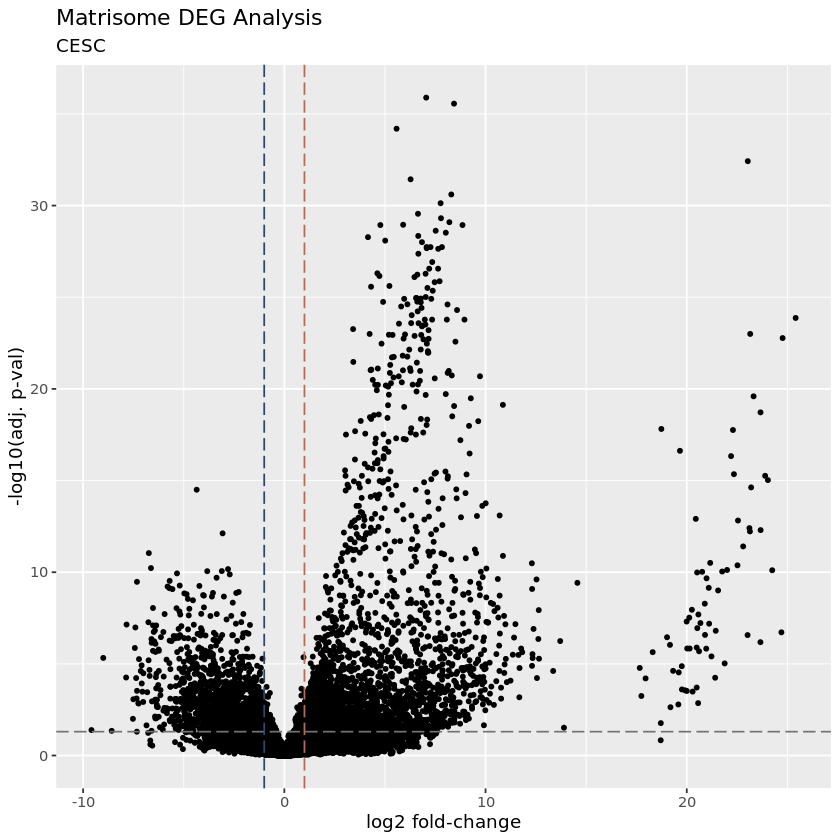

In [6]:
make_vplot(matrisome_vplot_df, jitter_h = 0, jitter_w = 0.3)
ggsave(paste(dirs$figures_dir, "all_matrisome_vplot.png", sep = "/"), last_plot())
make_vplot(all_gene_vplot_df, jitter_h = 0, jitter_w = 0.3)
ggsave(paste(dirs$figures_dir, "all_genes_vplot.png", sep = "/"), last_plot())

## Sankey diagram

In [7]:
sd_df <- dge_matrisome_rj_df %>%
    mutate(gene_list = rep("Matrisome genes", nrow(dge_matrisome_rj_df))) %>%
    mutate(in_dset = ifelse(in_unified_dataset, "In dataset", "Not in dataset")) %>%
    mutate(DEG_cat = ifelse(padj < 0.05, "Sig. DEGs", "Non-sig. DEGs")) %>%
    select(gene_list, in_dset, DEG_cat, category)
# Some genes are present in the dataset, but unexpressed in both conditions
present_unexpressed_mask <- sd_df$in_dset == "In dataset" & is.na(sd_df$DEG_cat)
sd_df[present_unexpressed_mask, ]$DEG_cat = "Non-sig. DEGs"
head(sd_df)

gene_list,in_dset,DEG_cat,category
<chr>,<chr>,<chr>,<chr>
Matrisome genes,In dataset,Non-sig. DEGs,Secreted Factors
Matrisome genes,In dataset,Non-sig. DEGs,ECM Regulators
Matrisome genes,In dataset,Non-sig. DEGs,ECM-affiliated Proteins
Matrisome genes,In dataset,Non-sig. DEGs,ECM Glycoproteins
Matrisome genes,In dataset,Non-sig. DEGs,Secreted Factors
Matrisome genes,In dataset,Sig. DEGs,Proteoglycans


In [8]:
source_v = c()
target_v = c()
value_v = c()

In [9]:
# Matrisome list -> in or out of dataset?
sd1_df <- sd_df %>%
    group_by(gene_list, in_dset) %>%
    summarize(n = n()) %>%
    mutate(gene_list_with_n = paste0(gene_list, ": ", sum(n[gene_list == "Matrisome genes"]))) %>%
    mutate(in_dset_with_n = paste0(in_dset, ": ", n))
# sd1_df

source_v <- c(source_v, sd1_df$gene_list_with_n)
target_v <- c(target_v, sd1_df$in_dset_with_n)
value_v <- c(value_v, sd1_df$n)

# In dataset -> Sig. or Non-sig. DEGs?
sd2_df <- sd_df %>%
    group_by(in_dset, DEG_cat) %>%
    filter (in_dset == "In dataset") %>%
    summarize(n = n()) %>%
    mutate(in_dset_with_n = paste0(in_dset, ": ", sum(n[in_dset == "In dataset"]))) %>%
    mutate(DEG_cat_with_n = paste0(DEG_cat, ": ", n))
# sd2_df

source_v <- c(source_v, sd2_df$in_dset_with_n)
target_v <- c(target_v, sd2_df$DEG_cat_with_n)
value_v <- c(value_v, sd2_df$n)

# Sig. DEGs -> Matrisome category
sd3_df <- sd_df %>%
    mutate(category = replace(category, category == "ECM Glycoproteins", "Glycoproteins (ECM)")) %>%
    mutate(category = replace(category, category == "ECM Regulators", "Regulators (ECM)")) %>%
    group_by(DEG_cat, category) %>%
    filter(DEG_cat == "Sig. DEGs") %>%
    summarize(n = n()) %>%
    mutate(DEG_cat_with_n = paste0(DEG_cat, ": ", sum(n[DEG_cat == "Sig. DEGs"]))) %>%
    mutate(category_with_n = paste0(category, ": ", n))
# sd3_df

source_v <- c(source_v, sd3_df$DEG_cat_with_n)
target_v <- c(target_v, sd3_df$category_with_n)
value_v <- c(value_v, sd3_df$n)

`summarise()` regrouping output by 'gene_list' (override with `.groups` argument)
`summarise()` regrouping output by 'in_dset' (override with `.groups` argument)
`summarise()` regrouping output by 'DEG_cat' (override with `.groups` argument)


In [10]:
links_df <- tibble(
    source = source_v,
    target = target_v,
    value = value_v,
)

nodes_df <- tibble(
    name = c(links_df$source, links_df$target) %>% unique()
)

links_df$sourceID <- match(links_df$source, nodes_df$name) - 1
links_df$targetID <- match(links_df$target, nodes_df$name) - 1

In [11]:
color_dom <- as.vector(nodes_df$name)
color_range <- c("#0066cc", "#0099cc", "#ff9933", "#ffcc99", "#009933", "#669900", "#cc0066", "#cc9900", "#9933ff", "#006666", "#cc0000")

In [12]:
# Argument to colourScale needs to be a string, so string-ify lists and combine everything
dom_str <- paste0('.domain(["', paste0(color_dom, collapse = '", "'), '"])')
range_str <- paste0('.range(["', paste0(color_range, collapse = '", "'), '"])')
color_str <- paste('d3.scaleOrdinal()', dom_str, range_str, sep = " ")

In [13]:
sn <- sankeyNetwork(
    Links = links_df,
    Nodes = nodes_df,
    Source = "sourceID",
    Target = "targetID",
    Value = "value",
    NodeID = "name",
    fontSize = 24,
    fontFamily = "calibri",
    colourScale = color_str,
    sinksRight=FALSE
)

Links is a tbl_df. Converting to a plain data frame.
Nodes is a tbl_df. Converting to a plain data frame.


In [14]:
sn

HTML widgets cannot be represented in plain text (need html)

In [15]:
# saveWidget(p, file=paste0( "/sankeyBasic1.html"))
saveNetwork(sn, paste(dirs$figures_dir, "matrisome_sankey_diagram.html", sep = "/"))
## Doesn't get it quite right -- may be better of doing manual screenshot of html
# webshot(paste(figures_dir, "matrisome_sankey_diagram.html", sep = "/"), paste(figures_dir, "matrisome_sankey_diagram.png", sep = "/"))